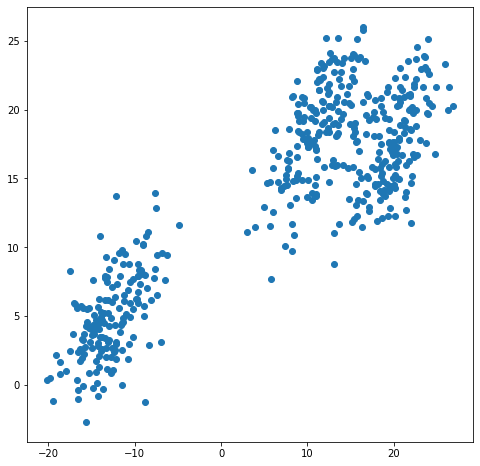

In [3]:

from sklearn.datasets.samples_generator import make_blobs
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt

X,Y = make_blobs(cluster_std=1.5,random_state=20,n_samples=500,centers=3)

X = np.dot(X, np.random.RandomState(0).randn(2,2))
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [0]:
class GMM2D:
    """Apply GMM to 2D data"""
    
    def __init__(self, num_clusters, max_iterations):

        """Initialize num_clusters(K) and max_iterations for the model"""

        self.num_clusters = num_clusters
        self.max_iterations = max_iterations

    def run(self, X):

        """Initialize parameters and run E and M step storing log-likelihood value after every iteration"""

        self.pi = np.ones(self.num_clusters)/self.num_clusters
        self.mu = np.random.randint(min(X[:, 0]), max(X[:, 0]), size=(self.num_clusters, len(X[0])))
        self.cov = np.zeros((self.num_clusters, len(X[0]), len(X[0])))

        for n in range(len(self.cov)):
            np.fill_diagonal(self.cov[n], 5)

        # reg_cov is used for numerical stability i.e. to check singularity issues in covariance matrix 
        self.reg_cov = 1e-6*np.identity(len(X[0]))

        x,y = np.meshgrid(np.sort(X[:,0]), np.sort(X[:,1]))
        self.XY = np.array([x.flatten(), y.flatten()]).T
        # Plot the data and the initial model

        fig0 = plt.figure(figsize=(10,10))
        ax0 = fig0.add_subplot(111)
        ax0.scatter(X[:, 0], X[:, 1])
        ax0.set_title("Initial State")

        for m, c in zip(self.mu, self.cov):
            c += self.reg_cov
            multi_normal = multivariate_normal(mean=m, cov=c)
            ax0.contour(np.sort(X[:, 0]), np.sort(X[:, 1]), multi_normal.pdf(self.XY).reshape(len(X), len(X)), colors = 'black', alpha = 0.3)
            ax0.scatter(m[0], m[1], c='grey', zorder=10, s=100)
        
        fig0.savefig('GMM2D Initial State.png')
        plt.show()
        self.log_likelihoods = []

        for iters in range(self.max_iterations):
            # E-Step

            self.ric = np.zeros((len(X), len(self.mu)))

            for pic, muc, covc, r in zip(self.pi, self.mu, self.cov, range(len(self.ric[0]))):
                covc += self.reg_cov
                mn = multivariate_normal(mean=muc, cov=covc)
                self.ric[:, r] = pic*mn.pdf(X)

            for r in range(len(self.ric)):
                self.ric[r, :] = self.ric[r, :] / np.sum(self.ric[r, :])

            # M-step

            self.mc = np.sum(self.ric, axis=0)
            self.pi = self.mc/np.sum(self.mc)
            self.mu = np.dot(self.ric.T, X) / self.mc.reshape(self.num_clusters,1)

            self.cov = []

            for r in range(len(self.pi)):
                covc = 1/self.mc[r] * (np.dot( (self.ric[:, r].reshape(len(X), 1)*(X-self.mu[r]) ).T, X - self.mu[r]) + self.reg_cov)
                self.cov.append(covc)

            self.cov = np.asarray(self.cov)
            self.log_likelihoods.append(np.log(np.sum([self.pi[r]*multivariate_normal(self.mu[r], self.cov[r] + self.reg_cov).pdf(X) for r in range(len(self.pi))])))

            fig1 = plt.figure(figsize=(10,10))
            ax1 = fig1.add_subplot(111)
            ax1.scatter(X[:, 0], X[:, 1])
            ax1.set_title("Iteration " + str(iters))

            for m, c in zip(self.mu, self.cov):
                c += self.reg_cov
                multi_normal = multivariate_normal(mean=m, cov=c)
                ax1.contour(np.sort(X[:, 0]), np.sort(X[:, 1]), multi_normal.pdf(self.XY).reshape(len(X), len(X)), colors = 'black', alpha = 0.3)
                ax1.scatter(m[0], m[1], c='grey', zorder=10, s=100)
            
            fig1.savefig("GMM2D Iter " + str(iters) + ".png")
            plt.show()

        fig2 = plt.figure(figsize=(10,10))
        ax2 = fig2.add_subplot(111)
        ax2.plot(range(0, iters+1, 1), self.log_likelihoods)
        ax2.set_title('Log Likelihood Values')
        fig2.savefig('GMM2D Log Likelihood.png')
        plt.show()

    def predict(self, Y):

        """Predicting cluster for new samples in array Y"""

        predictions = []

        for pic, m, c in zip(self.pi, self.mu, self.cov):
            prob = pic*multivariate_normal(mean=m, cov=c).pdf(Y)
            predictions.append([prob])

        predictions = np.asarray(predictions).reshape(len(Y), self.num_clusters)
        predictions = np.argmax(predictions, axis=1)

        fig2 = plt.figure(figsize=(10,10))
        ax2 = fig2.add_subplot(111)
        ax2.scatter(X[:, 0], X[:, 1], c='c')
        ax2.scatter(Y[:, 0], Y[:, 1], marker='*', c='k', s=150, label = 'New Data')
        ax2.set_title("Predictions on New Data")

        colors = ['r', 'b', 'g']

        for m, c, col, i in zip(self.mu, self.cov, colors, range(len(colors))):
    #         c += reg_cov
            multi_normal = multivariate_normal(mean=m, cov=c)
            ax2.contour(np.sort(X[:, 0]), np.sort(X[:, 1]), multi_normal.pdf(self.XY).reshape(len(X), len(X)), colors = 'black', alpha = 0.3)
            ax2.scatter(m[0], m[1], marker='o', c=col, zorder=10, s=150, label = 'Centroid ' + str(i+1))

        for i in range(len(Y)):
            ax2.scatter(Y[i, 0], Y[i, 1], marker='*', c=colors[predictions[i]], s=150)

        ax2.set_xlabel('X-axis')
        ax2.set_ylabel('Y-axis')
        ax2.legend()
        fig2.savefig('GMM2D Predictions.png')
        plt.show()

        return predictions

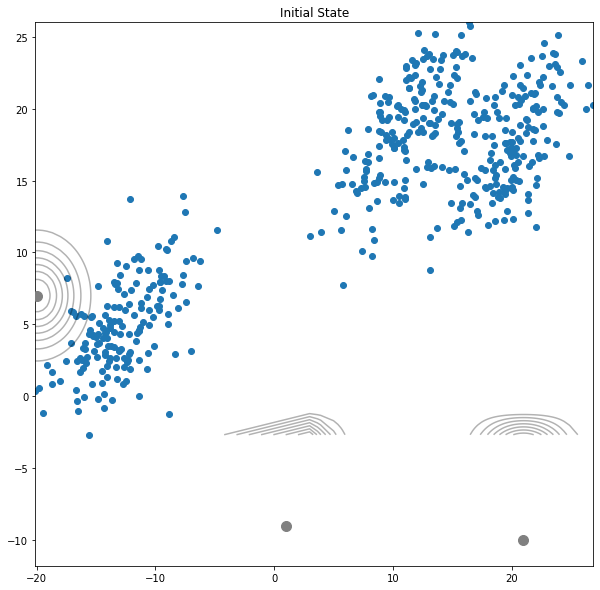

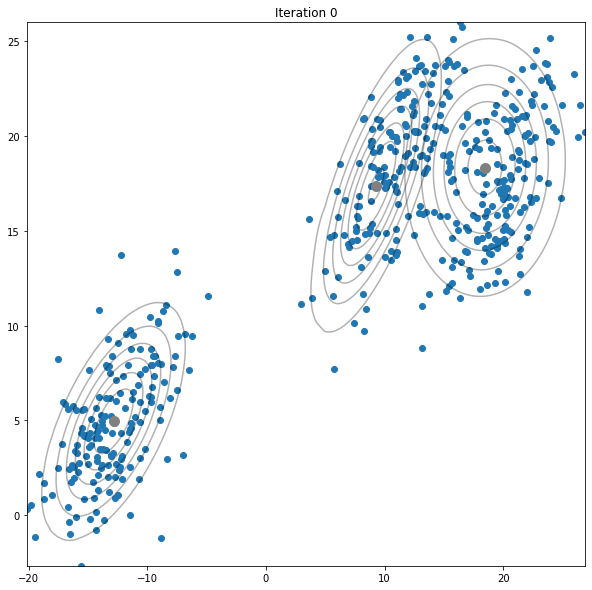

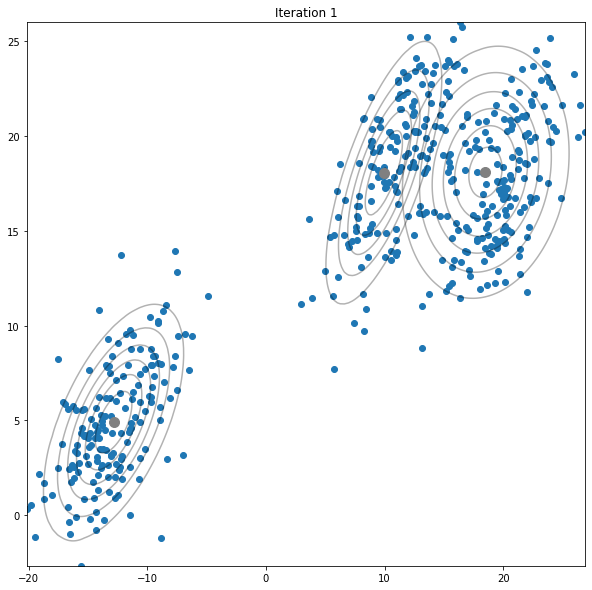

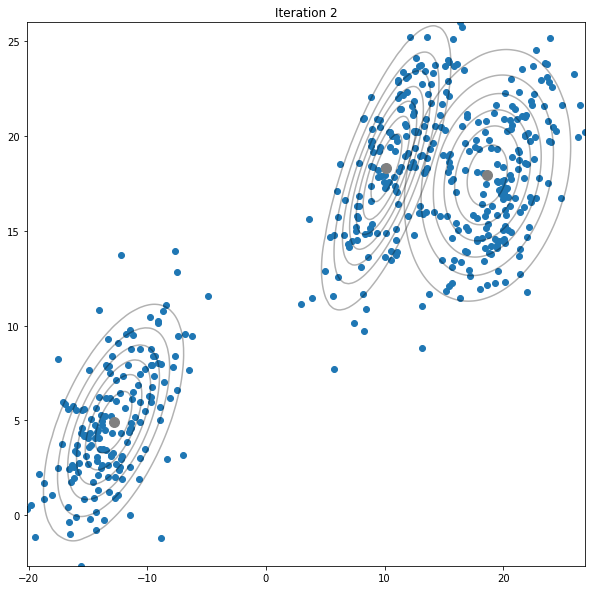

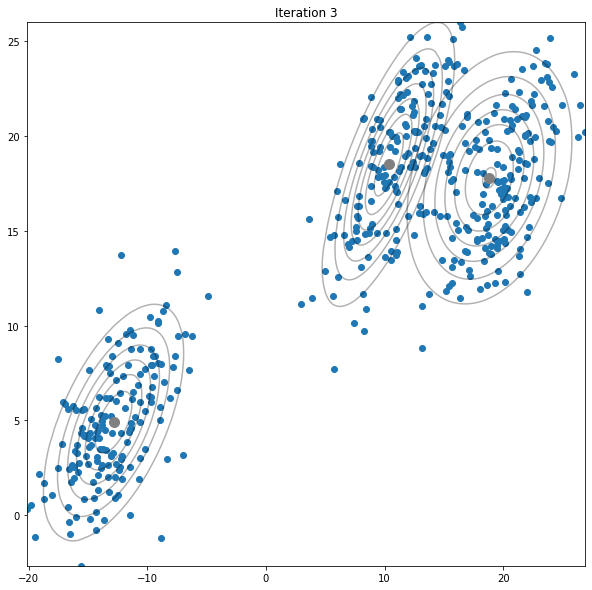

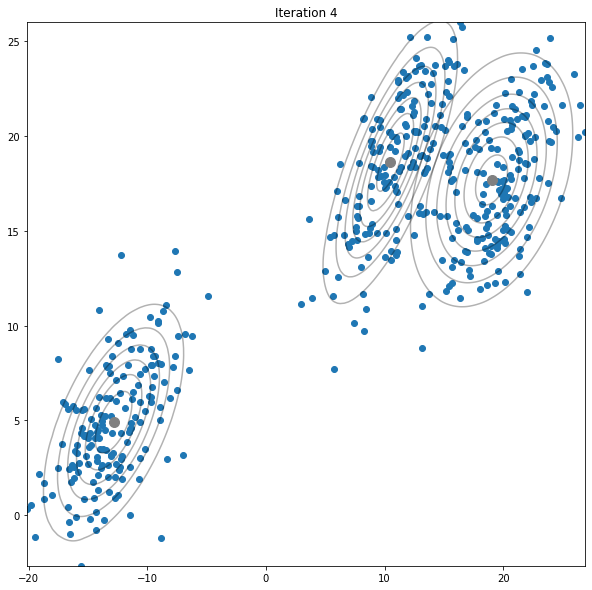

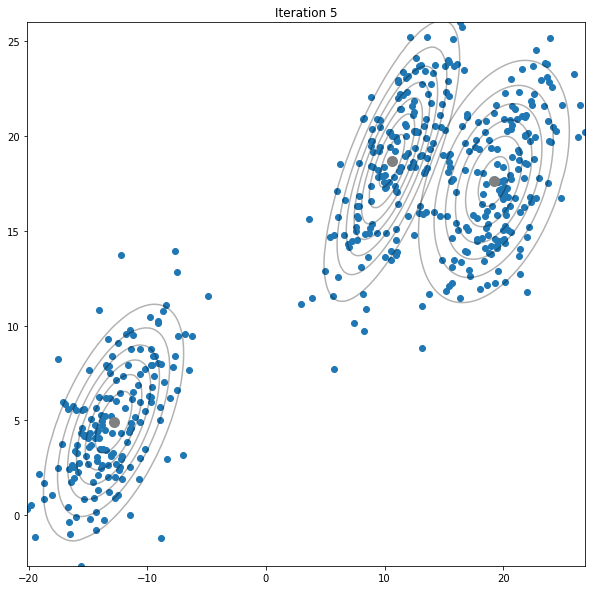

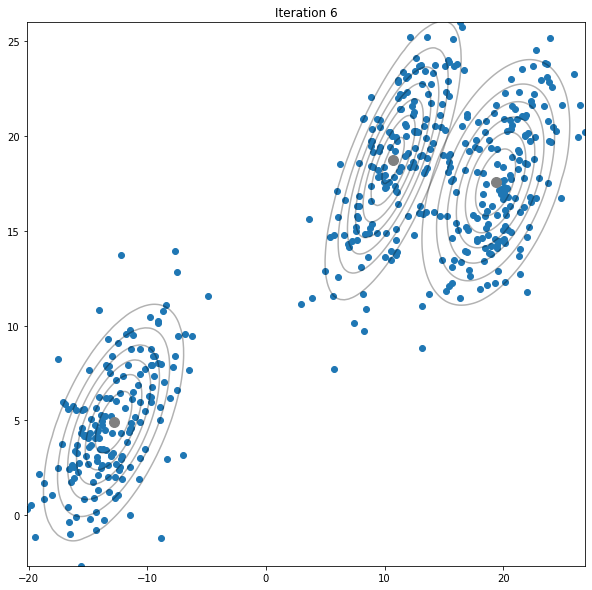

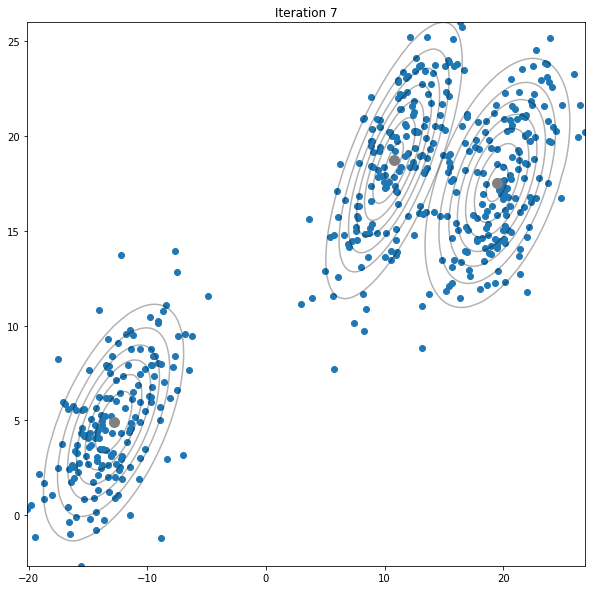

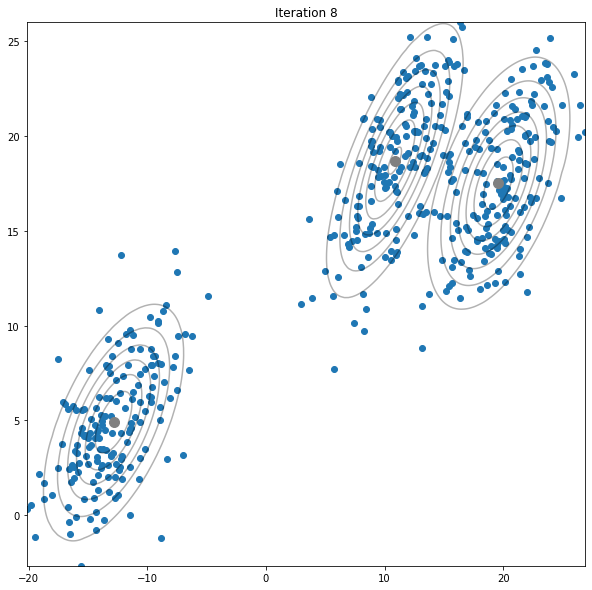

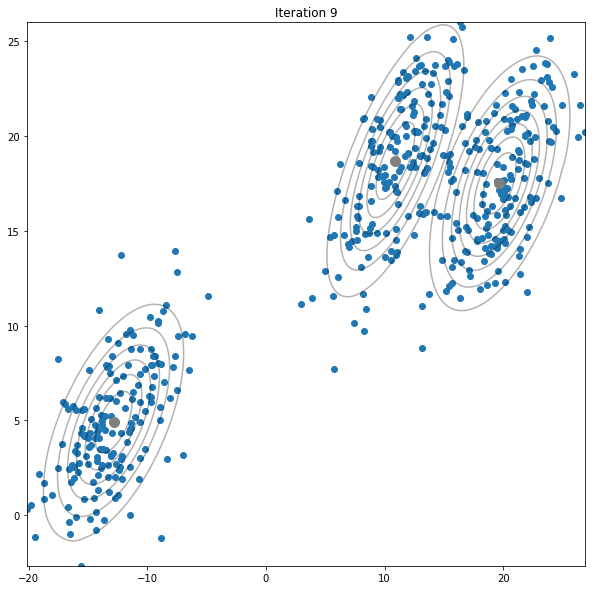

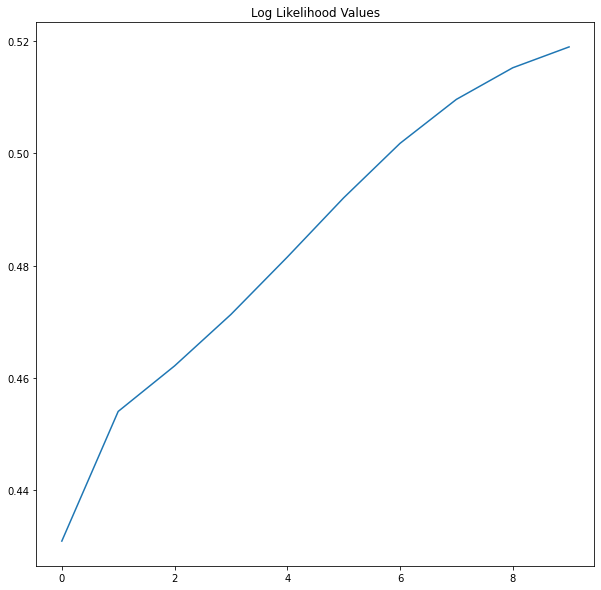

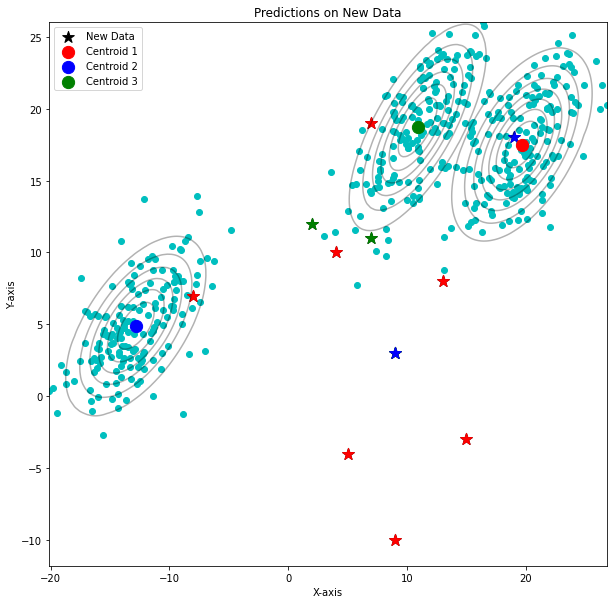

array([2, 0, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0])

In [5]:
y = np.random.randint(-10, 20, size=(12, 2))
gmm2d = GMM2D(num_clusters=3, max_iterations=10)
gmm2d.run(X)
gmm2d.predict(y)